Name: Sirinian Aram Emmanouil,
AM: 2537

Ερώτηση 1

Στην άσκηση αυτή θα εξασκηθείτε στην εφαρμογή αλγορίθμων κατηγοριοποίησης.

O στόχος σε αυτή την άσκηση είναι να διαχωρίσετε μεταξύ επιχειρήσεων που ανήκουν στις κατηγορίες ‘Nightlife’, ή ‘Bars’, και τις επιχειρήσεις που ανήκουν στις κατηγορίες ‘Cafes’, ‘Coffee & Tea’, ή ‘Breakfast & Brunch’. Θα  δουλέψετε  με  τις  επιχειρήσεις  από  την  περιοχή  του  Τορόντο.  Δημιουργήστε  τα  δεδομένα με  τις επιχειρήσεις, και εξάγετε χαρακτηριστικά από το κείμενο των reviews των επιχειρήσεων, καθώς και όποια άλλα χαρακτηριστικά πιστεύετε μπορούν να βοηθήσουν. Θα πειραματιστείτε με τέσσερεις classifiers: Logistic Regression, SVM, Decision  Trees,και Naïve Bayes. Για την αξιολόγηση θα χρησιμοποιήσετε 5-fold cross validation. Αναφέρετε τον μέσο confusion matrix και τις μετρικές accuracy, precision, recall και F1-measure.

Στην  αναφορά  σας  περιγράψετε  τα  χαρακτηριστικά  που  χρησιμοποιήσατε,  και  τα  αποτελέσματα  της κατηγοριοποίησης. Εξετάσετε επίσης τη  σημασία  που  δίνουν  στα διάφορα χαρακτηριστικά οι κατηγοριοποιητές (π.χ., τα βάρη που έχουν στον logistic regression classifier, ή τα πρώτα επίπεδα του decision tree), και προσπαθήστε να καταλάβετε ποιες λέξεις είναι που ξεχωρίζουν τις δύο κατηγορίες. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.utils as utils
import json
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.naive_bayes import BernoulliNB
%matplotlib inline

In this first part of the code, we are collecting useful data from business.json and review.json files. The selection is 
done by distinguishing specific category labels ("Coffee & Tea", "Cafes", "Breakfast & Brunch", "Nightlife", "Bars"). Using 5-fold cross validation we choose training and test sets.

In [2]:
all_businesses_in_Torronto = []
useful_businesses_in_Torronto = []

with open('business.json') as f:
    for line in f:
        try:
            if(json.loads(line.strip())["city"] == "Toronto"):
                all_businesses_in_Torronto.append({x: json.loads(line.strip())[x] for x in ["business_id", "categories"]})
        except ValueError:
                pass

In [3]:
print(len(all_businesses_in_Torronto))
all_businesses_in_Torronto

15483


[{'business_id': 'v2WhjAB3PIBA8J8VxG3wEg',
  'categories': ['Food', 'Coffee & Tea']},
 {'business_id': 'l9ABoPi9j_pH9588tk0-6w',
  'categories': ['Arts & Entertainment', 'Performing Arts']},
 {'business_id': 'qim0lD112TkDhm8ZyQlRnA',
  'categories': ['Pubs', 'Restaurants', 'Bars', 'Irish', 'Nightlife']},
 {'business_id': 'kEq7eudoX5qdcaSLAq3axw', 'categories': ['Bakeries', 'Food']},
 {'business_id': 'Wf5C8Amv_SlhoYE3_W66WQ',
  'categories': ['Asian Fusion', 'Restaurants', 'Sushi Bars']},
 {'business_id': 'Z1r6b30Tg0n0ME4-Zj2wQQ',
  'categories': ['American (Traditional)',
   'Restaurants',
   'Bars',
   'Pubs',
   'Beer',
   'Wine & Spirits',
   'Food',
   'Nightlife']},
 {'business_id': 'g2FSpf4OTWcQauAOWjoL-g',
  'categories': ['Nightlife',
   'Music Venues',
   'DJs',
   'Arts & Entertainment',
   'Performing Arts',
   'Event Planning & Services',
   'Venues & Event Spaces']},
 {'business_id': 'v86J4q6ATA2ANm1fc7yCNg',
  'categories': ['Nightlife',
   'Lounges',
   'Beer',
   'Wine 

In [4]:
def renameToNewCategoriesNames(i):
    if (("Coffee & Tea" in all_businesses_in_Torronto[i]["categories"]) or ("Cafes" in all_businesses_in_Torronto[i]["categories"]) or ("Breakfast & Brunch" in all_businesses_in_Torronto[i]["categories"])):
        all_businesses_in_Torronto[i]["categories"] = "coffee"
    if (("Nightlife" in all_businesses_in_Torronto[i]["categories"]) or ("Bars" in all_businesses_in_Torronto[i]["categories"])):
        all_businesses_in_Torronto[i]["categories"] = "bars"
    if ((all_businesses_in_Torronto[i]["categories"] != "coffee") and (all_businesses_in_Torronto[i]["categories"] != "bars")):
        all_businesses_in_Torronto[i]["categories"] = "trash"

In [5]:
def removeUnnecessaryReviews():
    for i in range(len(all_businesses_in_Torronto)):
        renameToNewCategoriesNames(i)
    
    for i in range(len(all_businesses_in_Torronto)):
        if(all_businesses_in_Torronto[i]["categories"] == "trash"):
            continue
        else:
            useful_businesses_in_Torronto.append(all_businesses_in_Torronto[i])

In [6]:
tempArray2 = []
removeUnnecessaryReviews()
df_useful_businesses_in_Torronto = pd.DataFrame.from_records(useful_businesses_in_Torronto)
for x in useful_businesses_in_Torronto:
    tempArray2.append(x["business_id"])
tempArray2 = set(tempArray2)

print(len(all_businesses_in_Torronto))
print(len(useful_businesses_in_Torronto))

15483
3117


In [7]:
useful_businesses_in_Torronto_dict = {x["business_id"]: x["categories"] for x in useful_businesses_in_Torronto}

In [8]:
reviews_in_Torronto = []

with open('review.json') as f:
    for line in f:
        try:
            if(json.loads(line.strip())["business_id"] in tempArray2):
                tempArray3 = [json.loads(line.strip())[x] for x in ["business_id", "text"]]
                tempArray3.append(useful_businesses_in_Torronto_dict[json.loads(line.strip())["business_id"]])
                reviews_in_Torronto.append(tempArray3)
        except ValueError:
                pass

In [9]:
reviews_in_Torronto_data = []
reviews_in_Torronto_target = []

for x in reviews_in_Torronto:
    reviews_in_Torronto_data.append(x[1])
    if(x[2] == "coffee"):
        reviews_in_Torronto_target.append(0)
    if(x[2] == "bars"):
        reviews_in_Torronto_target.append(1)

In [10]:
print(reviews_in_Torronto_data[:5])
print(reviews_in_Torronto_target[:5])

['Ok food and great service. The owners, family and staff really make the difference. Duncan is a great host and a pleasure to talk to. Small but comfortable atmosphere. \nGate 403 brings in wonderful jazz talent and they promote young talent. \nKeep up the great job!', "A very talented and musical friend of mine was playing a jazzy show here and I rarely if ever pass up an invite to hear live music. Almost every day of the week at Gate 403 you'll be sure to happen upon a few local jazz artists or bands who are simply playing their music for the love of it. Not only do I find this endearing, I also think it's perfect for those who wish to support local talent in Toronto. \n\nWhile Gate 403 is not a large space, it fits a nice crowd of people who are either there for the food or for the music. Both are safe bets if you ask me. Gate 403 is a mix between a pub and a piano bar and it seems to have something for everyone. Come in for the food and stay for the tunes, either way you'll be hap

In [11]:
########### 5-fold cross validation #########################

X, y = utils.shuffle(reviews_in_Torronto_data, reviews_in_Torronto_target, random_state=1) #shuffle the data
train_set_size = round(len(reviews_in_Torronto_data)/5)
X_test = X[:train_set_size]
y_test = y[:train_set_size]
X_train = X[train_set_size:]
y_train = y[train_set_size:]

In [12]:
target_names = ["coffee", "bars"]

Now that we collected our sets of training and test data, we test various classification algorithms.

accuracy score:  0.85943843754
             precision    recall  f1-score   support

          0       0.89      0.84      0.86     12458
          1       0.83      0.88      0.85     10941

avg / total       0.86      0.86      0.86     23399



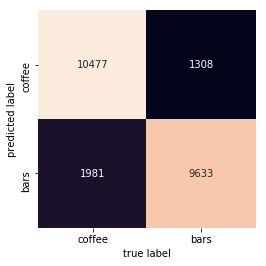

In [13]:
################### TfidfVectorizer ==> Naïve Bayes Multinomial ##############################
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

accuracy score:  0.778152912518
             precision    recall  f1-score   support

          0       0.76      0.86      0.80     12458
          1       0.81      0.69      0.74     10941

avg / total       0.78      0.78      0.78     23399



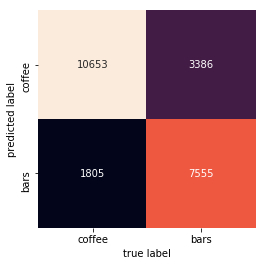

In [14]:
################### TfidfVectorizer ==> Naïve Bayes Bernoulli ##############################
model = make_pipeline(TfidfVectorizer(), BernoulliNB())
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Coefficient of the features in the decision function: [[-0.46393835 -0.00559762 -0.01278525 ..., -0.11904624  0.04989826
  -0.08892536]]
Intercept (a.k.a. bias) added to the decision function: [-0.12815072]
Actual number of iterations for all classes: [7]
accuracy score:  0.865207914868
             precision    recall  f1-score   support

          0       0.90      0.84      0.87     12458
          1       0.83      0.89      0.86     10941

avg / total       0.87      0.87      0.87     23399



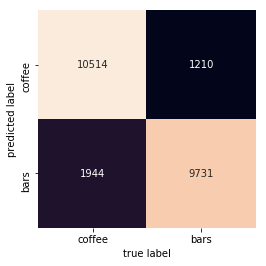

In [15]:
#################### TfidfVectorizer ==> Logistic Regression #############################
model = TfidfVectorizer()
tfidf = model.fit_transform(X_train)
model = LogisticRegression()
model = model.fit(tfidf, y_train)

print("Coefficient of the features in the decision function: " + str(model.coef_))
print("Intercept (a.k.a. bias) added to the decision function: " + str(model.intercept_ ))
print("Actual number of iterations for all classes: " + str(model.n_iter_))

model = make_pipeline(TfidfVectorizer(), LogisticRegression())
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

accuracy score:  0.769861959913
             precision    recall  f1-score   support

          0       0.79      0.78      0.78     12458
          1       0.75      0.76      0.75     10941

avg / total       0.77      0.77      0.77     23399



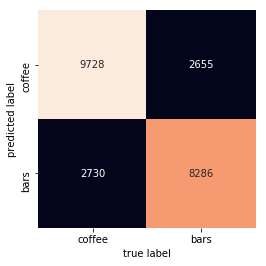

In [16]:
####################### TfidfVectorizer ==> Decision Trees ############################
model = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Weights assigned to the features: [[-0.16446365 -0.12527549  0.         ..., -0.20597106  0.15638964
  -0.17507529]]
Constants in decision function: [-0.02299581]
accuracy score:  0.862900123937
             precision    recall  f1-score   support

          0       0.89      0.85      0.87     12458
          1       0.84      0.88      0.86     10941

avg / total       0.86      0.86      0.86     23399



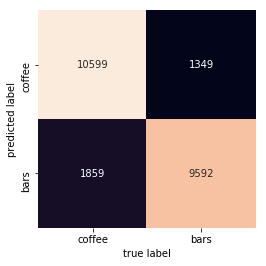

In [17]:
############################ TfidfVectorizer ==> LinearSVC(penalty="l2") ##################################
model = TfidfVectorizer()
tfidf = model.fit_transform(X_train)
model = LinearSVC(penalty="l2")
model = model.fit(tfidf, y_train)

print("Weights assigned to the features: " + str(model.coef_))
print("Constants in decision function: " + str(model.intercept_))

model = make_pipeline(TfidfVectorizer(), LinearSVC(penalty="l2"))
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In this part of the code, we are collecting useful data from business.json and review.json files. The selection is based by ("Coffee & Tea", "Cafes", "Breakfast & Brunch", "Nightlife", "Bars") category labels. More specifically by taking the union of categories which show together with the base categories we used before. Our target to dig out more data to use.
Using 5-fold cross validation we choose training and test sets.

In [18]:
all_businesses_in_Torronto = []

with open('business.json') as f:
    for line in f:
        try:
            if(json.loads(line.strip())["city"] == "Toronto"):
                all_businesses_in_Torronto.append({x: json.loads(line.strip())[x] for x in ["business_id", "categories"]})
        except ValueError:
                pass

In [19]:
print(len(all_businesses_in_Torronto))
all_businesses_in_Torronto

15483


[{'business_id': 'v2WhjAB3PIBA8J8VxG3wEg',
  'categories': ['Food', 'Coffee & Tea']},
 {'business_id': 'l9ABoPi9j_pH9588tk0-6w',
  'categories': ['Arts & Entertainment', 'Performing Arts']},
 {'business_id': 'qim0lD112TkDhm8ZyQlRnA',
  'categories': ['Pubs', 'Restaurants', 'Bars', 'Irish', 'Nightlife']},
 {'business_id': 'kEq7eudoX5qdcaSLAq3axw', 'categories': ['Bakeries', 'Food']},
 {'business_id': 'Wf5C8Amv_SlhoYE3_W66WQ',
  'categories': ['Asian Fusion', 'Restaurants', 'Sushi Bars']},
 {'business_id': 'Z1r6b30Tg0n0ME4-Zj2wQQ',
  'categories': ['American (Traditional)',
   'Restaurants',
   'Bars',
   'Pubs',
   'Beer',
   'Wine & Spirits',
   'Food',
   'Nightlife']},
 {'business_id': 'g2FSpf4OTWcQauAOWjoL-g',
  'categories': ['Nightlife',
   'Music Venues',
   'DJs',
   'Arts & Entertainment',
   'Performing Arts',
   'Event Planning & Services',
   'Venues & Event Spaces']},
 {'business_id': 'v86J4q6ATA2ANm1fc7yCNg',
  'categories': ['Nightlife',
   'Lounges',
   'Beer',
   'Wine 

In [20]:
categories_related_with_bars = ["Bars", "Nightlife"]
categories_related_with_coffee = ["Coffee & Tea", "Cafes", "Breakfast & Brunch"]

temp_businesses_related_with_bars = []
temp_businesses_related_with_coffee = []

for i in range(len(all_businesses_in_Torronto)):
    for x in categories_related_with_bars:
        if(x in all_businesses_in_Torronto[i]["categories"]):
            temp_businesses_related_with_bars.append(i)
    for x in categories_related_with_coffee:
        if(x in all_businesses_in_Torronto[i]["categories"]):
            temp_businesses_related_with_coffee.append(i)

for x in temp_businesses_related_with_bars:
    for y in all_businesses_in_Torronto[x]["categories"]:
        if(y not in categories_related_with_bars):
            categories_related_with_bars.append(y)

for x in temp_businesses_related_with_coffee:
    for y in all_businesses_in_Torronto[x]["categories"]:
        if(y not in categories_related_with_coffee):
            categories_related_with_coffee.append(y)

In [21]:
print(len(categories_related_with_bars))
print(len(categories_related_with_coffee))

#compute Intersection of categories arrays
tempArray = list(set(categories_related_with_coffee) & set(categories_related_with_bars))
print(len(tempArray))

#delete Intersections from categories arrays
for x in tempArray:
    categories_related_with_bars.remove(x)
    categories_related_with_coffee.remove(x)

print(len(categories_related_with_bars))
print(len(categories_related_with_coffee))

225
241
159
66
82


In [22]:
def renameToNewCategoriesNames(i):
    for x in categories_related_with_coffee:
        if(x in all_businesses_in_Torronto[i]["categories"]):
            all_businesses_in_Torronto[i]["categories"] = "coffee"
            break

    for x in categories_related_with_bars:
        if(x in all_businesses_in_Torronto[i]["categories"]):
            all_businesses_in_Torronto[i]["categories"] = "bars"
            break
        
    if( (all_businesses_in_Torronto[i]["categories"] != "coffee") and (all_businesses_in_Torronto[i]["categories"] != "bars") ):
        all_businesses_in_Torronto[i]["categories"] = "trash"

In [23]:
useful_businesses_in_Torronto = []

def removeUnnecessaryReviews():
    for i in range(len(all_businesses_in_Torronto)):
        renameToNewCategoriesNames(i)
    
    for i in range(len(all_businesses_in_Torronto)):
        if(all_businesses_in_Torronto[i]["categories"] == "trash"):
            continue
        else:
            useful_businesses_in_Torronto.append(all_businesses_in_Torronto[i])

In [24]:
tempArray2 = []
removeUnnecessaryReviews()
df_useful_businesses_in_Torronto = pd.DataFrame.from_records(useful_businesses_in_Torronto)
for x in useful_businesses_in_Torronto:
    tempArray2.append(x["business_id"])
tempArray2 = set(tempArray2)

In [25]:
print(len(all_businesses_in_Torronto))
print(len(useful_businesses_in_Torronto))

15483
5400


In [26]:
count_businesses_related_with_bars = 0
count_businesses_related_with_coffee = 0

for x in useful_businesses_in_Torronto:
    if(x["categories"] == "bars"):
        count_businesses_related_with_bars += 1
    if(x["categories"] == "coffee"):
        count_businesses_related_with_coffee += 1

print(count_businesses_related_with_bars)
print(count_businesses_related_with_coffee)

1717
3683


In [27]:
useful_businesses_in_Torronto_dict = {x["business_id"]: x["categories"] for x in useful_businesses_in_Torronto}

In [28]:
reviews_in_Torronto = []

with open('review.json') as f:
    for line in f:
        try:
            if(json.loads(line.strip())["business_id"] in tempArray2):
                tempArray3 = [json.loads(line.strip())[x] for x in ["business_id", "text"]]
                tempArray3.append(useful_businesses_in_Torronto_dict[json.loads(line.strip())["business_id"]])
                reviews_in_Torronto.append(tempArray3)
        except ValueError:
                pass

In [29]:
reviews_in_Torronto

[['rPiS3Vt3usEE8tkDQNrObg',
  'Great selection of hockey stuff, jerseys and gift stuff. Pricey, but if you want hockey stuff, they have it.\n\nYou enter here upon existing the Hockley Hall of Fame, or you can enter from the indoor mall. \n\nFood and drink are just outside if you are exhausted and thirsty.',
  'coffee'],
 ['rPiS3Vt3usEE8tkDQNrObg',
  'The Spirit of Hockey is technically the gift-shop for the Hockey Hall of Fame but you can still enter from the main entrance even if you don\'t want to go through the museum (even though you definitely should!)\n\nThis store is pretty much exactly as you\'d expect: wall-to-wall memorabilia of all your favourite NHL teams. While I was mystified at first, it quickly wore off. It kind of became of game of laughing at all the ridiculous things you can stick a logo on (would you like some novelty cups to go with your keychain??) \n\nHowever, the fact of the matter is that people do buy them so obviously there is a market for these things. I act

In [30]:
reviews_in_Torronto_data = []
reviews_in_Torronto_target = []

for x in reviews_in_Torronto:
    reviews_in_Torronto_data.append(x[1])
    if(x[2] == "coffee"):
        reviews_in_Torronto_target.append(0)
    if(x[2] == "bars"):
        reviews_in_Torronto_target.append(1)

In [31]:
X, y = utils.shuffle(reviews_in_Torronto_data, reviews_in_Torronto_target, random_state=1) #shuffle the data
train_set_size = round(len(reviews_in_Torronto_data)/5)
X_test = X[:train_set_size]
y_test = y[:train_set_size]
X_train = X[train_set_size:]
y_train = y[train_set_size:]

In [32]:
target_names = ["coffee", "bars"]

In [33]:
#How TfidfVectorizer work anyway?
vectorizer = TfidfVectorizer()
tempValue = vectorizer.fit_transform(["Hello world", "Welcome to our world"])
print(tempValue)
print(tempValue.toarray())

  (0, 0)	0.814802474667
  (0, 4)	0.579738671538
  (1, 4)	0.379978361591
  (1, 3)	0.534046329052
  (1, 2)	0.534046329052
  (1, 1)	0.534046329052
[[ 0.81480247  0.          0.          0.          0.57973867]
 [ 0.          0.53404633  0.53404633  0.53404633  0.37997836]]


Now that we collected our sets of training and test data, we test various classification algorithms.

accuracy score:  0.841099773243
             precision    recall  f1-score   support

          0       0.82      0.99      0.89     11904
          1       0.95      0.54      0.69      5736

avg / total       0.86      0.84      0.83     17640



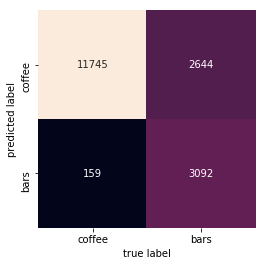

In [34]:
################### TfidfVectorizer ==> Naïve Bayes Multinomial ##############################
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

accuracy score:  0.85612244898
             precision    recall  f1-score   support

          0       0.86      0.94      0.90     11904
          1       0.85      0.68      0.76      5736

avg / total       0.86      0.86      0.85     17640



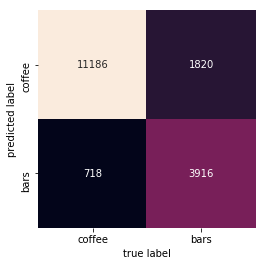

In [35]:
################### TfidfVectorizer ==> Naïve Bayes Bernoulli ##############################
model = make_pipeline(TfidfVectorizer(), BernoulliNB())
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Coefficient of the features in the decision function: [[-0.41106191  0.17889803 -0.0325908  ..., -0.01085912  0.01058974
  -0.0570946 ]]
Intercept (a.k.a. bias) added to the decision function: [-0.77571593]
Actual number of iterations for all classes: [11]
accuracy score:  0.909126984127
             precision    recall  f1-score   support

          0       0.92      0.95      0.93     11904
          1       0.89      0.82      0.85      5736

avg / total       0.91      0.91      0.91     17640



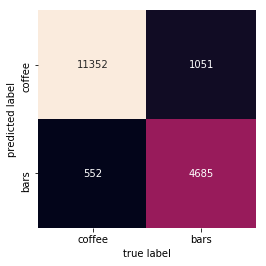

In [36]:
#################### TfidfVectorizer ==> Logistic Regression #############################
model = TfidfVectorizer()
tfidf = model.fit_transform(X_train)
model = LogisticRegression()
model = model.fit(tfidf, y_train)

print("Coefficient of the features in the decision function: " + str(model.coef_))
print("Intercept (a.k.a. bias) added to the decision function: " + str(model.intercept_ ))
print("Actual number of iterations for all classes: " + str(model.n_iter_))

model = make_pipeline(TfidfVectorizer(), LogisticRegression())
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

accuracy score:  0.822392290249
             precision    recall  f1-score   support

          0       0.87      0.87      0.87     11904
          1       0.72      0.73      0.73      5736

avg / total       0.82      0.82      0.82     17640



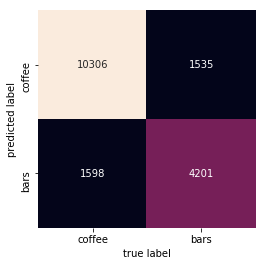

In [37]:
####################### TfidfVectorizer ==> Decision Trees ############################
model = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Weights assigned to the features: [[-0.27874176  0.22571876 -0.04888326 ..., -0.03196314  0.01969902
  -0.09743721]]
Constants in decision function: [-0.33023053]
accuracy score:  0.91201814059
             precision    recall  f1-score   support

          0       0.93      0.94      0.94     11904
          1       0.88      0.85      0.86      5736

avg / total       0.91      0.91      0.91     17640



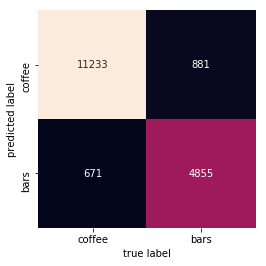

In [38]:
############################ TfidfVectorizer ==> LinearSVC(penalty="l2") ##################################
model = TfidfVectorizer()
tfidf = model.fit_transform(X_train)
model = LinearSVC(penalty="l2")
model = model.fit(tfidf, y_train)

print("Weights assigned to the features: " + str(model.coef_))
print("Constants in decision function: " + str(model.intercept_))

model = make_pipeline(TfidfVectorizer(), LinearSVC(penalty="l2"))
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

accuracy score:  0.909693877551
             precision    recall  f1-score   support

          0       0.95      0.92      0.93     11904
          1       0.84      0.89      0.87      5736

avg / total       0.91      0.91      0.91     17640



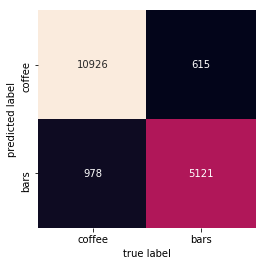

In [39]:
############################ TfidfVectorizer ==> LinearSVC(class_weight='balanced') ##################################
model = make_pipeline(TfidfVectorizer(), LinearSVC(class_weight='balanced'))
model.fit(X_train,y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

At this point of the code, we are trying to implement dimensionality reduction algorithms to our data before using our classification techniques. 

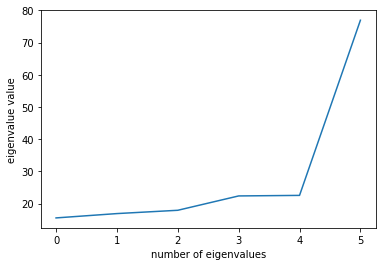

#############
[ 15.56190693  16.90690506  17.93385007  22.38841819  22.55762974
  76.95034197]
#############
0.0311232980467
0.0367356908848
0.0413339636832
0.064417935939
0.0653953565557
0.760993754891
#############
0.890807047385


In [40]:
vectorizer = TfidfVectorizer()
tempArray = vectorizer.fit_transform(X_train)
#Subtract off the mean for each measurement type
scaler = StandardScaler(with_mean=False)
scaler.fit(tempArray)
scaled_data = scaler.transform(tempArray)
# PCA with 2 components
pca = TruncatedSVD(n_components=2)
pca.fit(scaled_data, y_train)
x_pca = pca.transform(scaled_data)

U, s, V = svds(tempArray)
plt.plot(s[:])
plt.ylabel('eigenvalue value')
plt.xlabel('number of eigenvalues')
plt.show()
print("#############")
print(s)
print("#############")
s2 = [pow(x, 2) for x in s]
print(abs(s2[0])/abs(np.sum(s2)))
print(abs(s2[1])/abs(np.sum(s2)))
print(abs(s2[2])/abs(np.sum(s2)))
print(abs(s2[3])/abs(np.sum(s2)))
print(abs(s2[4])/abs(np.sum(s2)))
print(abs(s2[5])/abs(np.sum(s2)))
print("#############")
print(abs(s2[5] + s2[4] + s2[3])/abs(np.sum(s2)))

Now that we collected our sets of training and test data, we test various classification algorithms.

In [41]:
############## TfidfVectorizer ==> TruncatedSVD(n_components=2) ==> Naïve Bayes Multinomial ###########################
model = make_pipeline(TfidfVectorizer(), TruncatedSVD(n_components=2), MultinomialNB())
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

ValueError: Input X must be non-negative

accuracy score:  0.674829931973
             precision    recall  f1-score   support

          0       0.67      1.00      0.81     11904
          1       0.00      0.00      0.00      5736

avg / total       0.46      0.67      0.54     17640



/home/aram/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


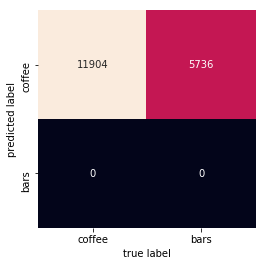

In [44]:
################### TfidfVectorizer ==> TruncatedSVD(n_components=2) ==> Naïve Bayes Bernoulli ##############################
from sklearn.naive_bayes import BernoulliNB
model = make_pipeline(TfidfVectorizer(), TruncatedSVD(n_components=2), BernoulliNB())
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

accuracy score:  0.674829931973
             precision    recall  f1-score   support

          0       0.67      1.00      0.81     11904
          1       0.00      0.00      0.00      5736

avg / total       0.46      0.67      0.54     17640



/home/aram/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


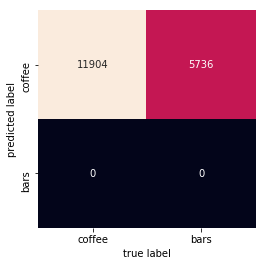

In [43]:
#################### TfidfVectorizer ==> TruncatedSVD(n_components=2) ==> Logistic Regression #############################
model = make_pipeline(TfidfVectorizer(), TruncatedSVD(n_components=2), LogisticRegression())
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

accuracy score:  0.567743764172
             precision    recall  f1-score   support

          0       0.68      0.67      0.68     11904
          1       0.34      0.35      0.35      5736

avg / total       0.57      0.57      0.57     17640



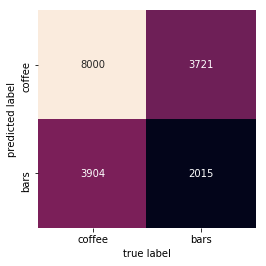

In [45]:
####################### TfidfVectorizer ==> TruncatedSVD(n_components=2) ==> Decision Trees ############################
model = make_pipeline(TfidfVectorizer(), TruncatedSVD(n_components=2), DecisionTreeClassifier())
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

accuracy score:  0.674829931973
             precision    recall  f1-score   support

          0       0.67      1.00      0.81     11904
          1       0.00      0.00      0.00      5736

avg / total       0.46      0.67      0.54     17640



/home/aram/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


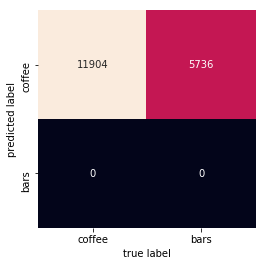

In [42]:
################### TfidfVectorizer ==> TruncatedSVD(n_components=2) ==> LinearSVC(penalty="l2") #########################
model = make_pipeline(TfidfVectorizer(), TruncatedSVD(n_components=2), LinearSVC(penalty="l2"))
model.fit(X_train, y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Finally we use of some techniques of extracting information that doesn't seem to work with our data.

In [46]:
####################### Tfidf Vectorizer ############################
model = TfidfVectorizer()
tfidf = model.fit_transform(X_train)
print(type(tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


In [43]:
tfidf = tfidf.toarray()

MemoryError: 

In [44]:
########## DecisionTreeClassifier graphviz ##########
import graphviz
from sklearn.tree import export_graphviz

model = DecisionTreeClassifier()
model = model.fit(tfidf, y_train)
dot_data = export_graphviz(model, out_file=None)
graph = graphviz.Source(dot_data)
graph

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [45]:
############################ TfidfVectorizer ==> LinearSVC(penalty="l1") ##################################
model = make_pipeline(TfidfVectorizer(), LinearSVC(penalty="l1"))
model.fit(X_train,y_train)
labels = model.predict(X_test)

print("accuracy score: ", accuracy_score(y_test, labels))
print(classification_report(y_test, labels))
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True